In [ ]:
import keras
from keras import metrics
import tensorflow as tf
from keras import losses
import numpy as np
from keras import layers
from keras import optimizers

In [ ]:
# Custom VAE class

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }



In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Dimensionality of sampled latent vector.
latent_dim = 32

In [ ]:
# Encoder
encoder_inputs = keras.Input(shape=(60, 60, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 60, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 30, 30, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 30, 30, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 30, 30, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [ ]:
# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(15 * 15 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((15, 15, 128))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="tanh", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 28800)             950400    
_________________________________________________________________
reshape (Reshape)            (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 30, 30, 64)        73792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 60, 60, 32)        1846

In [ ]:
# Training the model

# loads all the anime face images resized to 60x60
x_train = np.load("/content/drive/MyDrive/anime_faces.npy")
print("x_train shape : ", x_train.shape)

# We'll not use the entire dataset to avoid memory running out
x_train = x_train[:15000]

# Scaling all Images
x_train = x_train / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002), metrics=["accuracy"]) 

vae.fit(x_train, epochs=1000, batch_size=64)

x_train shape :  (63565, 60, 60, 3)
Epoch 1/1000
235/235 [==============================] - 6s 20ms/step - loss: 2037.6814 - reconstruction_loss: 2022.6761 - kl_loss: 12.9546
Epoch 2/1000
235/235 [==============================] - 5s 19ms/step - loss: 2036.3213 - reconstruction_loss: 2021.8292 - kl_loss: 12.9891
Epoch 3/1000
235/235 [==============================] - 5s 19ms/step - loss: 2033.7220 - reconstruction_loss: 2021.8063 - kl_loss: 12.9797
Epoch 4/1000
235/235 [==============================] - 5s 19ms/step - loss: 2033.7206 - reconstruction_loss: 2021.7313 - kl_loss: 13.0324
Epoch 5/1000
235/235 [==============================] - 5s 19ms/step - loss: 2033.9042 - reconstruction_loss: 2021.5641 - kl_loss: 13.0376
Epoch 6/1000
235/235 [==============================] - 4s 19ms/step - loss: 2034.3250 - reconstruction_loss: 2021.5875 - kl_loss: 13.0161
Epoch 7/1000
235/235 [==============================] - 4s 19ms/step - loss: 2035.8007 - reconstruction_loss: 2023.0685 - kl_loss:

KeyboardInterrupt: ignored

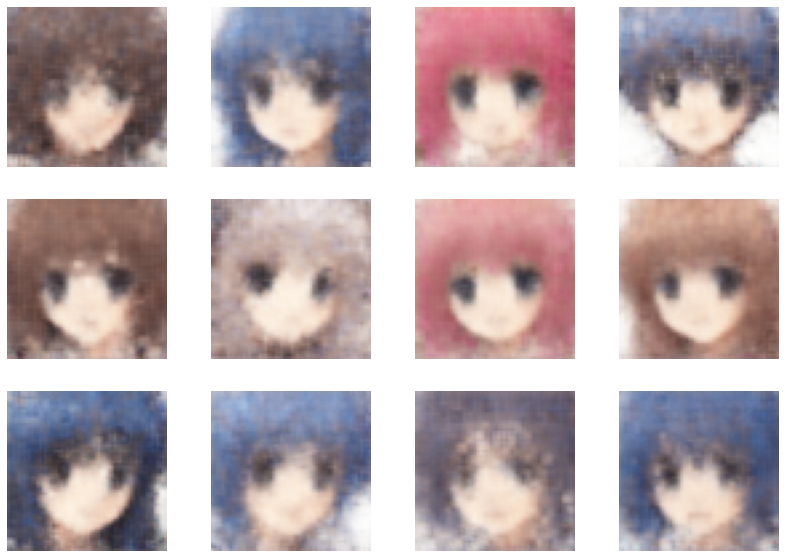

In [ ]:
# Generating new Images using the Decoder as a standalone model.

import cv2
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
for i in range(12):
    # creating list of random numbers from Std Normal distribution.
    # list will have same length as latent_dim
    random_nums = np.random.normal(loc=0, scale=1, size=latent_dim)

    z_sample = np.array([random_nums])
    x_decoded = vae.decoder.predict(z_sample)
    image = x_decoded[0].reshape(60, 60,3)
    image = np.clip(image,0,1)

    plt.subplot(3, 4, i + 1)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.show()

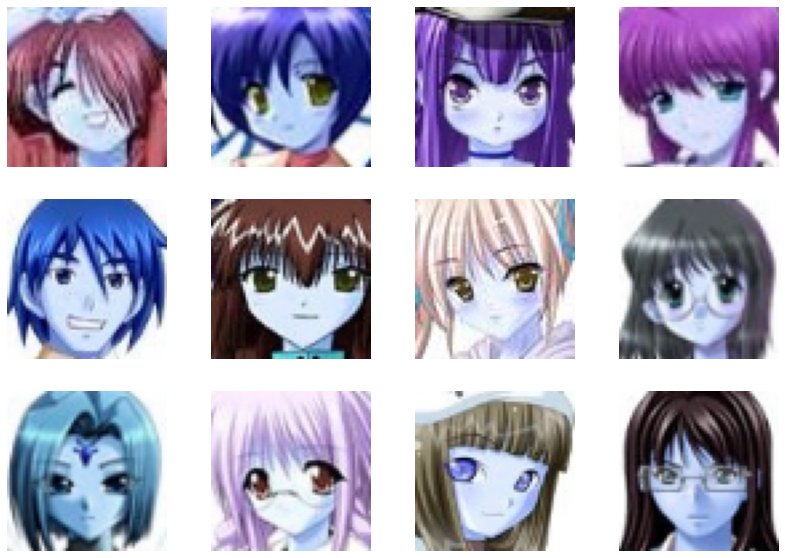

In [ ]:
# Plotting images from training dataset to compare.

plt.figure(figsize=(14,10))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.axis("off")
    plt.imshow(x_train[i], cmap="gray")
plt.show()